# An Introduction to the Pandas Python Library
Many of you will have heard of Pandas before. This is data handlying Python library, which utilises a Tabular format of data structure called a DataFrame. This is a very logical, and easy way to keep track of data, apply functions to that data and append more data to it.

In this example Notebook, I will create a DataFrame from a .csv file. This CSV file contains details of a set of sources from the COSMOS2020 catalogue (I have extracted them from the much larger dataset [here](https://irsa.ipac.caltech.edu/data/COSMOS/overview.html)). This dataset contains an identifier, the right ascenion and declination of the sources. I also have two further CSV files with some information about those sources. Mainly, the SED fitted stellar masses and star formation rates.

In this Notebook, I will demonstrate:

    1. How to import each CSV file, and do some initial exploration of the data.
    2. How to merge two DataFrames.
    3. How to make plots directly from DataFrame columns.
    4. How to apply a simple function to a DataFrame.
    5. How to apply an advanced function to a DataFrame.

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()

import os

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u

## Loading Data into a DataFrame
First, we need to load our dataset into the Notebook. The data is simply stored in the 'data' folder of the current working directory. Therefore, we use the os module to get this and then load the data into two DataFrames.

CSV files can easily be loaded into Pandas DataFrames using the `pd.read_csv` command as shown below.

In [2]:
cwd = os.getcwd()

In [3]:
df_coords = pd.read_csv(f'{cwd}/data/sample-coords.csv', index_col = 0)
df_params = pd.read_csv(f'{cwd}/data/sample-params.csv', index_col = 0)

We have now loaded two DataFrames. Both of these are extracts from the COSMOS2020 catalogue for 400 galactic sources. The first DataFrame, `df_coords`, contains an identifier of each source, the Right Ascension, Declination and the name of the FITS file they are contained in. The second DataFrame, `df_params` contains some extracted SED fitted parameters for the galaxies: the Stellar Masses (measured by LePhare) and the Star Formation Rates (measured by EAzY).

In [4]:
df_coords.head()

,ID,RA,Dec,file
0,769081,149.781408,2.153457,hst_9822_6j_acs_wfc_f814w_j8pu6j_drc.fits.gz
1,1325952,150.154525,2.679168,hst_10092_0y_acs_wfc_f814w_j8xi0y_drc.fits.gz
2,940968,150.107485,2.302701,hst_9822_44_acs_wfc_f814w_j8pu44_drc.fits.gz
3,1339492,150.133003,2.689801,hst_10092_0y_acs_wfc_f814w_j8xi0y_drc.fits.gz
4,942448,150.101225,2.310912,hst_9822_44_acs_wfc_f814w_j8pu44_drc.fits.gz


In [5]:
df_params.head()

,ID,stellar_mass,sfr
0,769081,9.37344,-0.070640
1,1325952,10.06106,1.452153
2,940968,10.45747,-1.503675
3,1339492,10.99362,1.272667
4,942448,11.21755,1.460878


In [6]:
len(df_coords)

129

The `.head()` command above simply prints the column headers and the first five entires in the DataFrame, rather than the whole thing.

## Merging Two DataFrames
If you're anything like me, dealing with two datasets can be quite annoying, and will lead to us repeating code. So, we can conduct a DataFrame `merge` on them. We can specify columns to merge the two DataFrames on. As the IDs in the two DataFrames are consistent with each other, we can select this column to merge on.

In [7]:
df_merged = (
    df_coords
    .merge(df_params, on = 'ID', how = 'left')
)

So, we have merged the two DataFrames. What do these look like?

In [8]:
df_merged.head()

,ID,RA,Dec,file,stellar_mass,sfr
0,769081,149.781408,2.153457,hst_9822_6j_acs_wfc_f814w_j8pu6j_drc.fits.gz,9.37344,-0.070640
1,1325952,150.154525,2.679168,hst_10092_0y_acs_wfc_f814w_j8xi0y_drc.fits.gz,10.06106,1.452153
2,940968,150.107485,2.302701,hst_9822_44_acs_wfc_f814w_j8pu44_drc.fits.gz,10.45747,-1.503675
3,1339492,150.133003,2.689801,hst_10092_0y_acs_wfc_f814w_j8xi0y_drc.fits.gz,10.99362,1.272667
4,942448,150.101225,2.310912,hst_9822_44_acs_wfc_f814w_j8pu44_drc.fits.gz,11.21755,1.460878


As you can see, Pandas has stitched the two DataFrames together based on the ID from COSMOS. It has then created one DataFrame with the Stellar Mass and SFR columns appended to the original coordinate DataFrame. We have used the `on` keyword to specify merging on the ID column. Then we have specified the `how` parameter to be 'left'. This means we have conducted an inner merge of the DataFrames. For a full explanation of an inner, outer, etc merge in Pandas see [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html). 

This command can get more complicated, if we want it to. We can specify merging on the index, rather than a column, and we can even specify different column names to merge the two DataFrames on. Let's set up this example below.

In [9]:
_df_coords = df_coords.set_index('ID')
_df_params = df_params.rename(columns = {'ID' : 'COSMOS2020_ID'})

So, to demonstrate this, I have created two additional DataFrames with some major differences to the originals. First, the coordinate DataFrame now has the index set to the `ID` column. This replaces the single indexer we had previously (which was just the order of the source) with the `ID` column. We have then used the `rename` command to access the DataFrame column names. We have then replaced the column name `ID` in the parameter DataFrame with `COSMOS2020_ID`.

In [10]:
_df_coords.head()

,RA,Dec,file
ID,,,
769081,149.781408,2.153457,hst_9822_6j_acs_wfc_f814w_j8pu6j_drc.fits.gz
1325952,150.154525,2.679168,hst_10092_0y_acs_wfc_f814w_j8xi0y_drc.fits.gz
940968,150.107485,2.302701,hst_9822_44_acs_wfc_f814w_j8pu44_drc.fits.gz
1339492,150.133003,2.689801,hst_10092_0y_acs_wfc_f814w_j8xi0y_drc.fits.gz
942448,150.101225,2.310912,hst_9822_44_acs_wfc_f814w_j8pu44_drc.fits.gz


In [11]:
_df_params.head()

,COSMOS2020_ID,stellar_mass,sfr
0,769081,9.37344,-0.070640
1,1325952,10.06106,1.452153
2,940968,10.45747,-1.503675
3,1339492,10.99362,1.272667
4,942448,11.21755,1.460878


We can now use the more complex form of the `.merge` operation to merge these two DataFrames.

In [12]:
_df_merge = (
    _df_coords
    .merge(_df_params, left_index = True, right_on = 'COSMOS2020_ID', how = 'left')
)

In [13]:
_df_merge.head()

,RA,Dec,file,COSMOS2020_ID,stellar_mass,sfr
0,149.781408,2.153457,hst_9822_6j_acs_wfc_f814w_j8pu6j_drc.fits.gz,769081,9.37344,-0.070640
1,150.154525,2.679168,hst_10092_0y_acs_wfc_f814w_j8xi0y_drc.fits.gz,1325952,10.06106,1.452153
2,150.107485,2.302701,hst_9822_44_acs_wfc_f814w_j8pu44_drc.fits.gz,940968,10.45747,-1.503675
3,150.133003,2.689801,hst_10092_0y_acs_wfc_f814w_j8xi0y_drc.fits.gz,1339492,10.99362,1.272667
4,150.101225,2.310912,hst_9822_44_acs_wfc_f814w_j8pu44_drc.fits.gz,942448,11.21755,1.460878


We have achieved the same thing as previously, using two separate keywords. The `left_index` (or `right_index`) is a boolean keyword which simply merges on the index of the DataFrame - not any of the columns. The `right_on` (or `left_on`) keyword is similar to the `on` keyword. It specifies the two columns to conduct the merge on.

## Making a Scatter Plot of Mass-SFR Directly from DataFrame
So, we now have our DataFrames combined, and we want to have a quick look at it. Let's quickly look at the relation between the `Log(Stellar Mass)` and the `Log(SFR)` columns, and plot them for any interesting structure. However, before we do this, Pandas offers us some easy ways to check our data. 

First, the LePhare and EAzY SED fitting algorithms are not perfect. Sometimes they fail, or they will produce numbers that don't look correct. In fact, above, we can see a `NaN` value in one of the EAzY values. So, let's get rid of those galaxies.

In [14]:
df_dna = df_merged.dropna()
print(len(df_dna))

127


The `.dropna()` function is applied to the whole DataFrame, and removes any rows which contain a NaN value. As we can see here, 16 of of our sources had the SED fitting algorithms fail to find the Stellar Mass or SFR. But, are the rest of the values reasonable? We can check this by looking at the min and max values of our columns.

In [16]:
print('Max and Min Log(Stellar Mass) values:')
print(df_dna.stellar_mass.max())
print(df_dna.stellar_mass.min())

Max and Min Log(Stellar Mass) values:
11.4544
7.83685


In [18]:
print('Max and Min SFR values:')
print(df_dna.sfr.max())
print(df_dna.sfr.min())

Max and Min SFR values:
2.093237611026774
-3.112989469362646


Ok, so the range of our Stellar Masses looks alright and reasonable (5.69 might be a little low, but we'll keep it for now). However, the SFR values are wildly too high or low. Likely, these are very poor FITS or some output from EAzY which indicates they are bad fits. To remove these, we can use the Pandas `query` command. This command applies a very simple selection function to a column of our choosing. 

In [20]:
df_quer = (
    df_dna
    .query('sfr >= -3.5 and sfr <= 3.5')
)
print(len(df_quer))

127


So, we apply our two conditions of having the SFR measurements be between -3.5 < `ez_sfr` < 3.5 and have removed a further 16 sources with bad fits (or, fits outwith our selected range). Now, with these selected limitations, let's look at a scatter plot of the Stellar Mass and the SFR. 

Normally, we would have to create arrays and then plot this with the MatPlotLib Python package. However, we can do this directly from the DataFrame using Pandas! We have a lot of keywords to play with, so there is a lot of freedom in how to make the plot.

<Axes: xlabel='Log(Stellar Mass)', ylabel='Log(SFR)'>

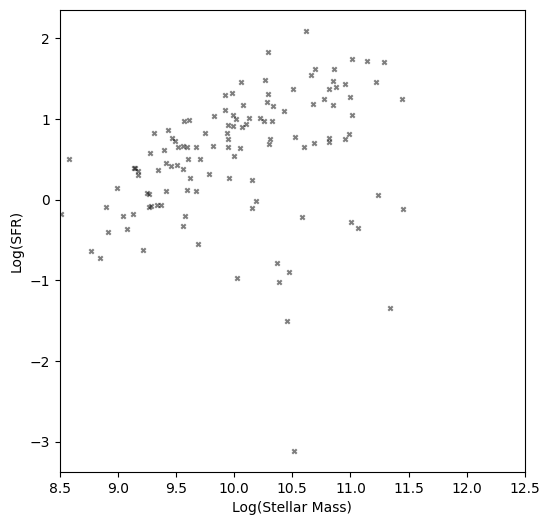

In [22]:
df_quer.plot.scatter( # We have selected to plot a scatter plot.
    x = 'stellar_mass', # We have selected the Stellar Mass column to be our x-axis.
    y = 'sfr', # We have selected the SFR measurements to be our y-axis.
    marker = 'x', # Let's make the plot pretty, and have x's as the marker.
    color = 'black', # Make the markers black.
    s = 10, # Change the size of the markers.
    alpha = 0.5, # Let's change the alpha in case there's lots of overlap.
    xlabel = 'Log(Stellar Mass)', # Set the xlabel.
    ylabel = 'Log(SFR)', # Set the ylabel.
    xlim = [8.5, 12.5], # Let's make the range of the x-axis a bit more reasonable.
    figsize = (6,6) # Let's make the FigSize pretty big.
)

And we have a nice scatter plot! These are randomnly selected galaxies, so tehre isn't much structure to them. We see we have quite a lot of starforming galaxies, compared to a much smaller red sequence below Log(SFR) = -1.5. This makes sense, as the majority of our galaxies are low mass and likely Late-Type galaxies.

But, can we check this? To check the morphology of the galaxies, we'll need to create some Cutouts from them...

## Applying a Function to our DataFrame
Our next step is to create some cutouts of our sources so we can actually check if our low mass, blue galaxies are indeed late-type galaxies. The first thing we need to do is convert our RA and Decs into SkyCoord objects. These can be used in Astropy to then create cutouts centered on those galaxies. 

To do this, we can use a `.assign` and `.apply` function to combine our RA and Dec columns into one SkyCoord column. The `.assign` function creates a new column with a name of our choosing. The `.apply` function then allows us to apply a function to one or more columns in our DataFrame which fill the new column created. It looks like the following...

In [24]:
df_coords = (
    df_quer
    .assign(coords = df_quer.apply(
        lambda row: 
            SkyCoord(ra = row.RA * u.deg, dec = row.Dec * u.deg, frame = 'fk5'), 
        axis = 1)
           )
)

In [25]:
df_coords.head()

,ID,RA,Dec,file,stellar_mass,sfr,coords
0,769081,149.781408,2.153457,hst_9822_6j_acs_wfc_f814w_j8pu6j_drc.fits.gz,9.37344,-0.070640,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ..."
1,1325952,150.154525,2.679168,hst_10092_0y_acs_wfc_f814w_j8xi0y_drc.fits.gz,10.06106,1.452153,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ..."
2,940968,150.107485,2.302701,hst_9822_44_acs_wfc_f814w_j8pu44_drc.fits.gz,10.45747,-1.503675,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ..."
3,1339492,150.133003,2.689801,hst_10092_0y_acs_wfc_f814w_j8xi0y_drc.fits.gz,10.99362,1.272667,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ..."
4,942448,150.101225,2.310912,hst_9822_44_acs_wfc_f814w_j8pu44_drc.fits.gz,11.21755,1.460878,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ..."


Ok, there's a lot going on here, so let's slow it down. The `.assign` function does what it says on the tin. It assigns a new column given the column name supplied in the function. This can be used in many ways, such as: `.assign(COLUMN_NAME = LIST_OF_LEN_DATAFRAME)`. This would simply fill the new column with the values of the list.

In our case, however, we want to fill this new column with the output of the `SkyCoord` function. Therefore, we choose to create an output List of SkyCoords that are generated by applying the `SkyCoord` function to the columns `ALPHA_J2000` and `DELTA_J2000`. We set `axis = 1` so that our lambda function is applied across the rows of the DataFrame. If `axis = 0`, the function will be applied across the columns of the DataFrame. I have never done this.

## Applying an Advanced Function to our DataFrame
So, we have our SkyCoords from applying the lambda function. However, this doesn't create our cutouts, only get's us one step closer. Well, this is where things get very complicated. The `.assign` and `.apply` functions don't just allow us to apply small functions to our columns. We can also build our own, complex functions to our DataFrames in the same way. I.e. we can build a cutout creator and apply it across all of our SkyCoords.

So, let's quickly build this cutout creator function. It's nothing fancy, just a very simple Cutout2D implementation with the FITS files.

In [26]:
def cutout_creator(fits_files, ids, coords, cwd):
    with fits.open(f'data/{fits_files.iloc[0]}') as hdul:
        header = hdul[1].header
        data = hdul[1].data
    hdul.close()
    del hdul
    
    w = WCS(header)
    
    save_paths = {}
    for id_str, coord in zip(list(ids), list(coords)):
        save_path = f'{cwd}/cutouts/{id_str}.fits'
        cutout = Cutout2D(data, coord, (75,75), wcs=w, mode = 'partial')
        
        cutout_data = cutout.data
        cutout_header = cutout.wcs.to_header()
        
        hdu_new = fits.PrimaryHDU(data = cutout_data, header = cutout_header)
        hdul = fits.HDUList([hdu_new])
        
        hdul.writeto(save_path, overwrite = True)
        
        save_paths[id_str] = save_path
        
        del hdul
        
    return save_paths

So, all our function does is take in the name of the FITS files, the cutout IDs, the coordinates we want to centre our cutout on and the current working directory to create a savepath. However, this means we're going to be opening and closing the loaded FITS file every single time we call this function, which isn't great. That will take forever. So, let's quickly see how many FITS files our sources are spread across.

In [27]:
df_coords.file.value_counts()

file
hst_10092_0y_acs_wfc_f814w_j8xi0y_drc.fits.gz    28
hst_9822_44_acs_wfc_f814w_j8pu44_drc.fits.gz     28
hst_9822_6j_acs_wfc_f814w_j8pu6j_drc.fits.gz     24
hst_9822_34_acs_wfc_f814w_j8pu34_drc.fits.gz     24
hst_9822_0n_acs_wfc_f814w_j8pu0n_drc.fits.gz     23
Name: count, dtype: int64

They are only split between 3 different FITS files! That means we can speed this process up massively. The final function that will be introduced in this Notebook is the `.groupby` function. This function is applied to a column, and creates sub-DataFrames based on matching entries in that column. We can then apply our Cutout Function to these sub-DataFrames.

I.e. what we can do is pass the list of IDs and source coordinates split up by FITS file to the Cutout function, open the FITS file once, create all of our Cutouts, close it and then open the next one. This is done in the following one line of code.

In [31]:
nested_paths = df_coords.groupby('file').progress_apply(lambda df: cutout_creator(df.file, df.ID, df.coords, cwd))

100%|██████████| 5/5 [00:06<00:00,  1.38s/it]


And there we have it! We have build out 368 cutouts in approximately 10 seconds. So, what do these look like? Well, a bit more admin first...

Unfortunately, the `groupby` function does not return a nicely appended DataFrame. It has returned a nested list of dictionaries. So, we can very quickly extract the correct values linked to their IDs.

In [32]:
paths_dict = {}
for i in nested_paths:
    for j in list(i.keys()):
        paths_dict[j] = i[j]
paths_df = pd.DataFrame.from_dict(paths_dict, orient = 'index', columns = ['cutout_paths'])

Once again, doing a simple merge, we can combine all of these together.

In [33]:
df_final = (
    df_coords
    .merge(paths_df, left_on = 'ID', right_index = True, how = 'left')
)

In [34]:
df_final.head()

,ID,RA,Dec,file,stellar_mass,sfr,coords,cutout_paths
0,769081,149.781408,2.153457,hst_9822_6j_acs_wfc_f814w_j8pu6j_drc.fits.gz,9.37344,-0.070640,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",/home/doryan/Documents/PyCoffee/cutouts/769081...
1,1325952,150.154525,2.679168,hst_10092_0y_acs_wfc_f814w_j8xi0y_drc.fits.gz,10.06106,1.452153,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",/home/doryan/Documents/PyCoffee/cutouts/132595...
2,940968,150.107485,2.302701,hst_9822_44_acs_wfc_f814w_j8pu44_drc.fits.gz,10.45747,-1.503675,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",/home/doryan/Documents/PyCoffee/cutouts/940968...
3,1339492,150.133003,2.689801,hst_10092_0y_acs_wfc_f814w_j8xi0y_drc.fits.gz,10.99362,1.272667,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",/home/doryan/Documents/PyCoffee/cutouts/133949...
4,942448,150.101225,2.310912,hst_9822_44_acs_wfc_f814w_j8pu44_drc.fits.gz,11.21755,1.460878,"<SkyCoord (FK5: equinox=J2000.000): (ra, dec) ...",/home/doryan/Documents/PyCoffee/cutouts/942448...


And now, we have our finished DataFrame! But, let's have a look at the Cutouts...

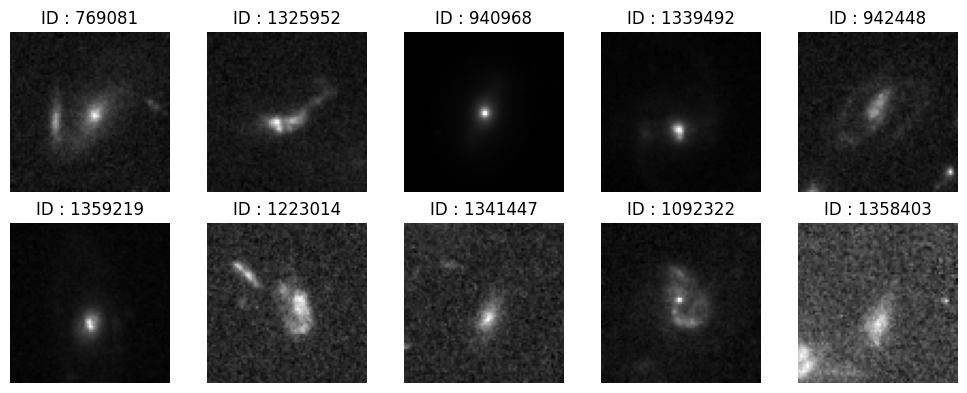

In [35]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (10,4))
for i, ax in enumerate(axes.flatten()):
    with fits.open(df_final.cutout_paths.iloc[i]) as hdul:
        data = hdul[0].data
    hdul.close()
    
    ax.imshow(data, origin = 'lower', cmap = 'gray')
    ax.set_title(f'ID : {df_final.ID.iloc[i]}')
    ax.axis('off')
    
fig.tight_layout()
plt.show()